# Ejercicio parte 3 : Modelo conceptual

Para este tutorial vamos a simular un flujo permanente de recarga, evapotranspiración y drenaje en una cuenca. Identificaremos zonas de recargar y de descarga.

EL acuífero de la cuenca es modelado con 5 estratos, los dos primeros son no acuíferos no confinados y los 3 últimos confinados. 

La tasa de evapotranspiración: 3.8 10^(-8) m/s 

Tasa de recarga: 4.7 10^(-9) m/s


In [2]:
from scipy.interpolate import griddata
from osgeo import osr
from osgeo import gdal
from osgeo import gdal_array
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd

from shapely.geometry import mapping
from shapely.geometry import Polygon, Point, MultiLineString
from collections import OrderedDict
import pandas as pd
import numpy as np

#plots
import matplotlib.pyplot as plt

#modflow
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import flopy.utils.binaryfile as bf

import os, json

import sys
sys.path.insert(0, '../src')
from meshProperties import mesh_shape

# Propiedades DISV

In [3]:
f=open('../examples/out/angascancha/json/disvDict.json')
gridprops = json.load(f)

In [4]:
cell2d = gridprops['cell2d']
vertices = gridprops['vertices']
ncpl = gridprops['ncpl']
nvert = gridprops['nvert']
centroids=[(x[0],x[1]) for x in gridprops['centroids']]

# Geometria del Acuifero

In [5]:
#Extact dem values for each centroid of the voronois
src = rasterio.open('../examples/in/rst/DEM_200b.tif')
elevation=[x for x in src.sample(centroids)]

In [6]:
nlay = 5

mtop=np.array([elev[0] for i,elev in enumerate(elevation)])
zbot=np.zeros((nlay,ncpl))


AcuifInf_Bottom = 3000
zbot[0,] = mtop - 30
zbot[1,] = AcuifInf_Bottom + (0.85 * (mtop - AcuifInf_Bottom))
zbot[2,] = AcuifInf_Bottom + (0.70 * (mtop - AcuifInf_Bottom))
zbot[3,] = AcuifInf_Bottom + (0.50 * (mtop - AcuifInf_Bottom))
zbot[4,] = AcuifInf_Bottom


# Creación del modelo Modflow 6

In [7]:
# create simulation
model_name = 'regional_model'
model_ws = '../examples/out/angascancha/model'
exe_name = '../exe/mf6.exe'

sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name,sim_ws=model_ws)

In [8]:
# create tdis package
tdis_rc = [(1.0, 1, 1.0)]
nper=len(tdis_rc)
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, time_units='seconds',perioddata=tdis_rc)

In [9]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, linear_acceleration='BICGSTAB')

In [10]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True, newtonoptions=['under_relaxation'])

In [11]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl,top=mtop, botm=zbot,nvert=nvert, vertices=vertices,cell2d=cell2d)

In [12]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)]))

In [13]:
Kx =[4E-4,5E-6,1E-6,9E-7,5E-7]
icelltype = [1,1,0,0,0]
npf = flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,icelltype=icelltype,k=Kx)

In [14]:
rchr = 0.15/365/86400
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rchr)
evtr = 1.2/365/86400
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0)

## Para insertar la red de drenaje se realiza una interceptacion entre el shp de rios y la grilla, de esta manera se optiene los indices de las celdas que conforman la red de drenaje

In [15]:
tgr = fgrid.VertexGrid(vertices, cell2d)

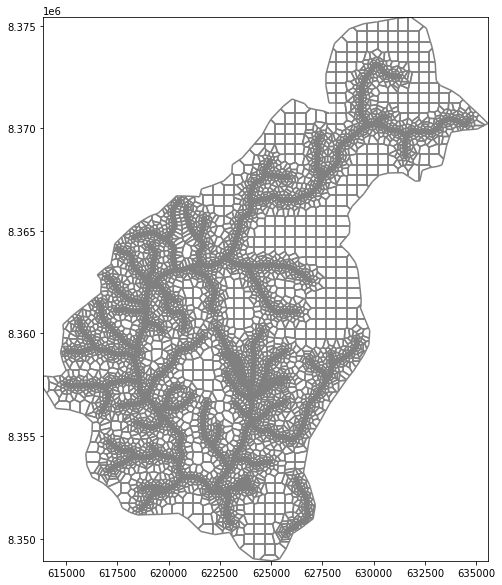

In [16]:
tgr = fgrid.VertexGrid(vertices, cell2d)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pmv = fplot.PlotMapView(modelgrid=tgr)
pmv.plot_grid(ax=ax)

In [17]:
ix2 = GridIntersect(tgr)

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\flopy\utils\gridintersect.py:337: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell


In [18]:
rios=gpd.read_file('../examples/in/shp/rios.shp')
list_rivers=[]
for i in range(rios.shape[0]):
    
    list_rivers.append(rios['geometry'].loc[i])
    
mls = MultiLineString(lines=list_rivers)
#intersec rivers with our grid
result=ix2.intersect(mls)

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\flopy\utils\gridintersect.py:1561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for part in ishp:


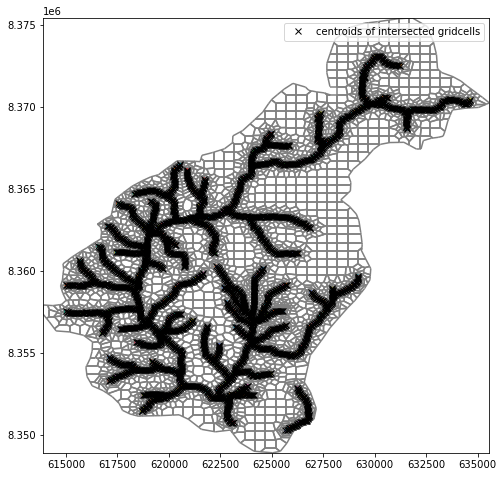

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_linestring(result, ax=ax, lw=3)

for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

In [20]:
#stress_period_data : [cellid, elev, cond, aux, boundname]
drain_list = []
for i in result.cellids:
    drain_list.append([0,i,mtop[i],0.001])
drain_spd = {0:drain_list}

In [21]:
drn = flopy.mf6.ModflowGwfdrn(gwf,stress_period_data=drain_spd)

In [22]:
hname = '{}.hds'.format(model_name)
cname = '{}.cbc'.format(model_name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
 head_filerecord=hname,
 saverecord=[('HEAD', 'ALL'), ('BUDGET',
'ALL')])

In [23]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model regional_model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package evta_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 3399 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 02 2022 15:29:04 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geologic

(False, [])

# plots

In [23]:
hds = bf.HeadFile(model_ws+'/'+model_name + '.hds')
head = hds.get_data(totim=1.0)
head[head==1e+30]=np.nan
cpth = os.path.join(model_ws, model_name+'.cbc')
cobj = flopy.utils.CellBudgetFile(cpth, precision=hds.precision)
spd = cobj.get_data(text='DATA-SPDIS')[0]

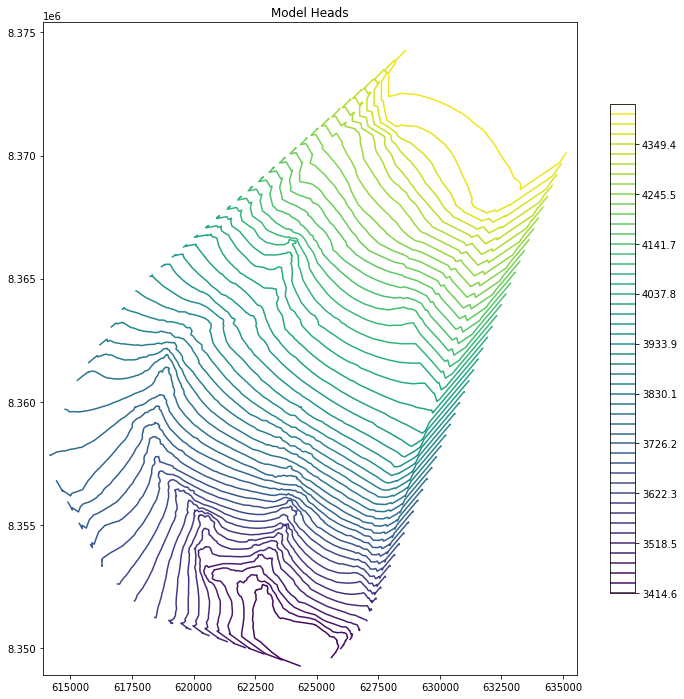

In [24]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)
#linecollection = mapview.plot_grid()

levels = np.linspace(np.nanmin(head),np.nanmax(head),num=50)
contour_set = mapview.contour_array(head,levels=levels)
t = ax.set_title("Model Heads")
plt.colorbar(contour_set, shrink=0.75)


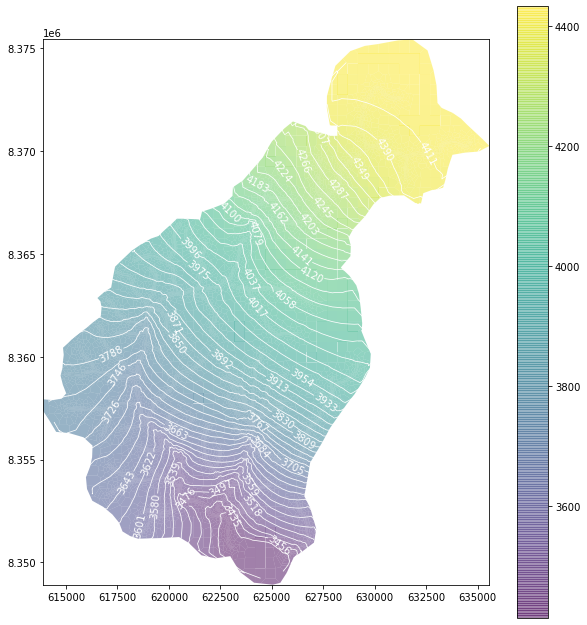

In [29]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)

quadmesh = mapview.plot_array(head, alpha=0.5)
levels = np.linspace(np.nanmin(head),np.nanmax(head),num=50)
c = mapview.contour_array(head, linewidths=0.75,colors='white',levels=levels)
plt.clabel(c, fmt='%3d')
#quiver = flopy.plot.plotutil.c(spd)
plt.colorbar(quadmesh, shrink=0.75)

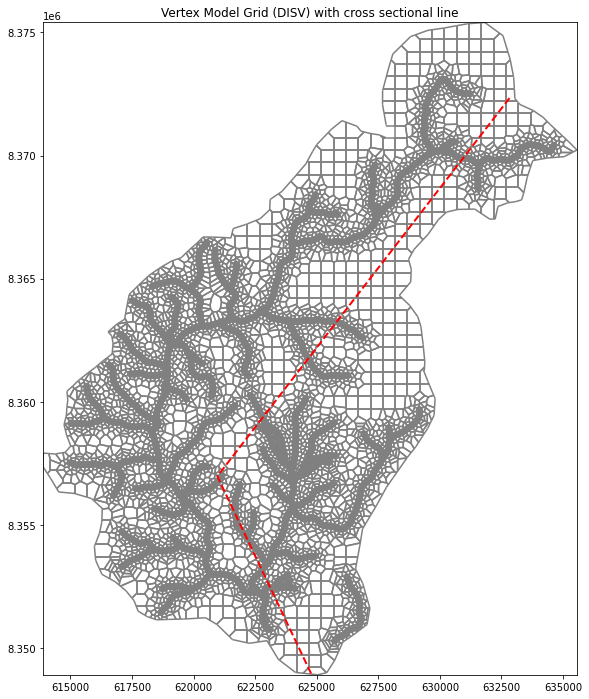

In [30]:
vertex_ml6=sim.get_model(model_name)
line = np.array([(624770.179,8348969.726), (620962.977,8356981.404), (632881.175,8372408.850)])

# Let's plot the model grid in map view to look at it
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Vertex Model Grid (DISV) with cross sectional line")

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(vertex_ml6, layer=0)
linecollection = mapview.plot_grid()

# plot the line over the model grid
lc = plt.plot(line.T[0], line.T[1], "r--", lw=2)

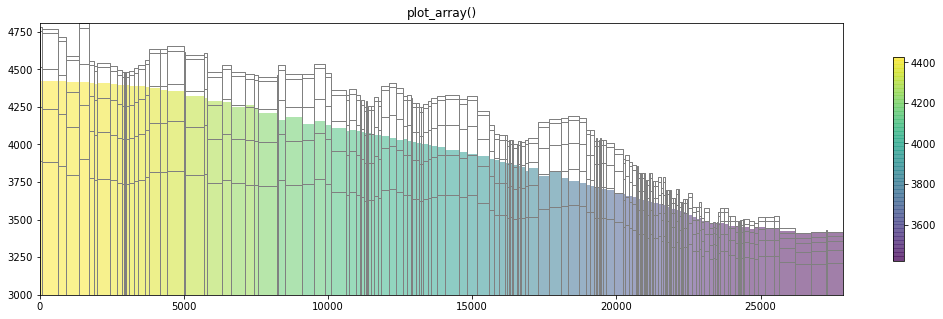

In [31]:
# get the head output for stress period 1 from the modflow6 head file
head = flopy.utils.HeadFile(os.path.join(model_ws, model_name+".hds"))
hdata = head.get_alldata()[0, :, :, :]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array()")

xsect = flopy.plot.PlotCrossSection(model=vertex_ml6, line={"line": line})
patch_collection = xsect.plot_array(hdata, head=hdata, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

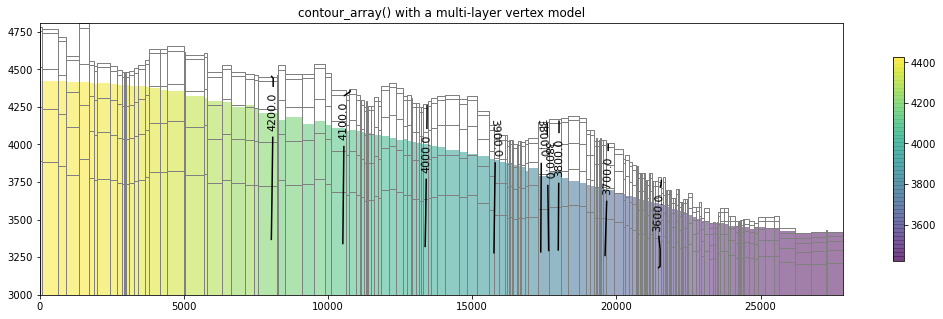

In [32]:
levels = np.arange(3600, 4300, 100)

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("contour_array() with a multi-layer vertex model")

xsect = flopy.plot.PlotCrossSection(model=vertex_ml6, line={"line": line})
patch_collection = xsect.plot_array(hdata, head=hdata, alpha=0.5)
line_collection = xsect.plot_grid()

contour_set = xsect.contour_array(hdata, levels=levels, colors="k")
plt.clabel(contour_set, fmt="%.1f", colors="k", fontsize=11)

cb = plt.colorbar(patch_collection, shrink=0.75)

In [48]:
hds = bf.HeadFile(model_ws+'/'+model_name + '.hds')
head = hds.get_data(totim=1.0)
head[head==1e+30]=np.nan
cpth = os.path.join(model_ws, model_name+'.cbc')
cobj = flopy.utils.CellBudgetFile(cpth, precision=hds.precision)
spd = cobj.get_data(text='DATA-SPDIS')[0]

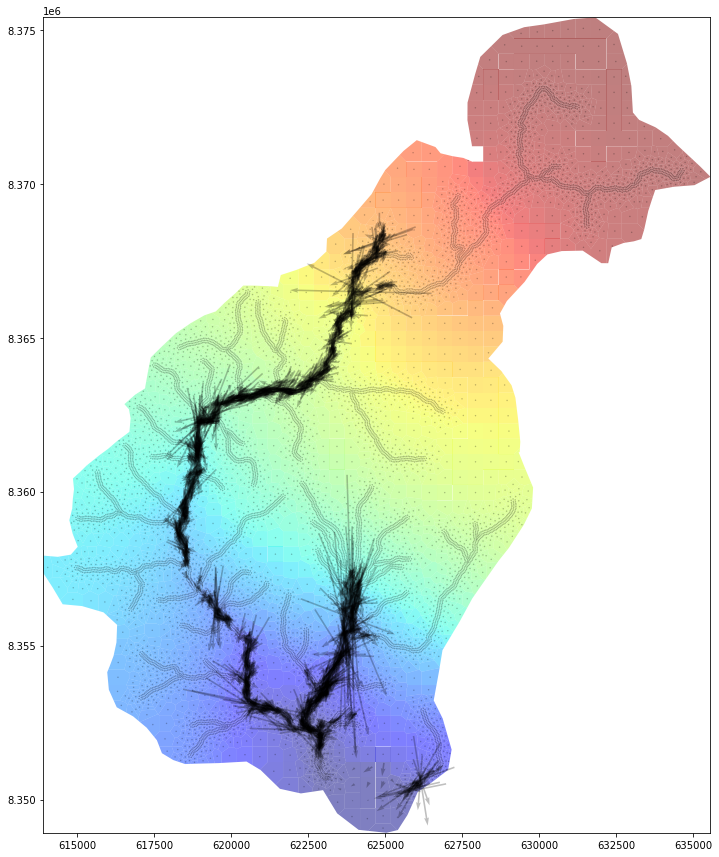

In [49]:
head = gwf.output.head().get_data()
bdobj = gwf.output.budget()
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head, cmap="jet", alpha=0.5)
pmv.plot_vector(spd["qx"], spd["qy"], alpha=0.25);

# Testeando vtks

In [29]:
from flopy.export import vtk

In [32]:
# output folder to store the outputs from the notebook
workspace = os.path.join('../examples/out/angascancha/', "vtk_outputs")
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

In [33]:
# create output folder
output_dir = os.path.join(workspace, "arrays_test")
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # export model top
#model_top_dir = os.path.join(output_dir, "TOP")
#disv.top.export(model_top_dir, fmt="vtk")

In [38]:
vtkobj=vtk.Vtk(gwf,vertical_exageration=10)

In [ ]:
## create some random array data
r_array = np.random.random(gwf.modelgrid.nnodes) * 100

## add random data to the VTK object
vtkobj.add_array(r_array, "random_data")

## add the model botom data to the VTK object
vtkobj.add_array(gwf.dis.top.array, "botm")

## write the vtk object to file
vtkobj.write(os.path.join(output_dir, "Array_example", "model.vtu"))

In [41]:
gwf.dis.top.array

array([4287., 4208., 4176., ..., 4594., 4573., 4577.])